In [1]:
# Import necessary libraries
import numpy as np
import torch
from matplotlib import pyplot as plt
from util import draw_reliability_diagram, calc_calibration_curve, cost_function

# Load your model
from solution import SWAGInference, InferenceType
from pathlib import Path

In [2]:
# Load training and validation datasets
def load_datasets(data_location):
    training_images = torch.from_numpy(np.load(data_location / "train_xs.npz")["train_xs"])
    training_metadata = np.load(data_location / "train_ys.npz")
    training_labels = torch.from_numpy(training_metadata["train_ys"])
    training_snow_labels = torch.from_numpy(training_metadata["train_is_snow"])
    training_cloud_labels = torch.from_numpy(training_metadata["train_is_cloud"])
    training_dataset = torch.utils.data.TensorDataset(training_images, training_snow_labels, training_cloud_labels, training_labels)

    validation_images = torch.from_numpy(np.load(data_location / "val_xs.npz")["val_xs"])
    validation_metadata = np.load(data_location / "val_ys.npz")
    validation_labels = torch.from_numpy(validation_metadata["val_ys"])
    validation_snow_labels = torch.from_numpy(validation_metadata["val_is_snow"])
    validation_cloud_labels = torch.from_numpy(validation_metadata["val_is_cloud"])
    validation_dataset = torch.utils.data.TensorDataset(validation_images, validation_snow_labels, validation_cloud_labels, validation_labels)

    return training_dataset, validation_dataset

# Load the model and perform inference
def load_model_and_predict(data_location, model_dir, num_samples=30):
    # Load datasets
    training_dataset, validation_dataset = load_datasets(data_location)
    
    # Load the model (SWAG-diagonal)
    swag_inference = SWAGInference(
        train_xs=training_dataset.tensors[0],
        model_dir=model_dir,
        inference_mode=InferenceType.SWAG_DIAGONAL,
        num_bma_samples=num_samples
    )
    
    # Load model and apply calibration
    swag_inference.fit(torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True))
    swag_inference.apply_calibration(validation_dataset)

    # Perform prediction on validation set
    images, _, _, labels = validation_dataset.tensors
    pred_probs = swag_inference.predict_probabilities(images)

    return pred_probs, labels, images

# Plot and display some example predictions
def plot_sample_predictions(pred_probs, images, labels, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))

    for i in range(num_samples):
        sample_idx = i
        # Show the image
        axs[i, 0].imshow(images[sample_idx].permute(1, 2, 0).numpy())
        axs[i, 0].axis('off')

        # Plot the predicted probabilities
        axs[i, 1].bar(range(pred_probs.shape[1]), pred_probs[sample_idx].detach().numpy())
        axs[i, 1].set_xticks(range(6))
        axs[i, 1].set_xlabel('Class')
        axs[i, 1].set_ylabel('Probability')
        axs[i, 1].set_title(f"True label: {labels[sample_idx].item()}")

    plt.tight_layout()
    plt.show()

# Plot reliability diagram
def plot_reliability_diagram(pred_probs, labels):
    calibration_data = calc_calibration_curve(pred_probs.numpy(), labels.numpy(), num_bins=20)
    fig = draw_reliability_diagram(calibration_data)
    plt.show()
    print(f"Expected Calibration Error (ECE): {calibration_data['ece']:.4f}")

# Visualize confidence distribution
def plot_confidence_histogram(pred_probs):
    confidences, _ = torch.max(pred_probs, dim=1)
    plt.hist(confidences.numpy(), bins=20, alpha=0.7)
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.title("Distribution of Prediction Confidences")
    plt.show()

# Main visualization function
def visualize_swag_diagonal(data_location, model_location):
    # Load model and prediction results
    pred_probs, labels, images = load_model_and_predict(data_location, model_location)

    # Plot sample predictions
    print("Plotting example predictions:")
    plot_sample_predictions(pred_probs, images, labels)

    # Plot reliability diagram
    print("Plotting reliability diagram:")
    plot_reliability_diagram(pred_probs, labels)

    # Plot confidence histogram
    print("Plotting confidence distribution:")
    plot_confidence_histogram(pred_probs)

Loaded pretrained MAP weights from /Users/igor/Desktop/PAI/Projects/task2_handout_e14a688d/map_weights.pt


/Users/igor/opt/miniconda3/envs/pai2/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Performing Bayesian model averaging: 100%|██████████| 30/30 [01:53<00:00,  3.77s/it]


Plotting example predictions:


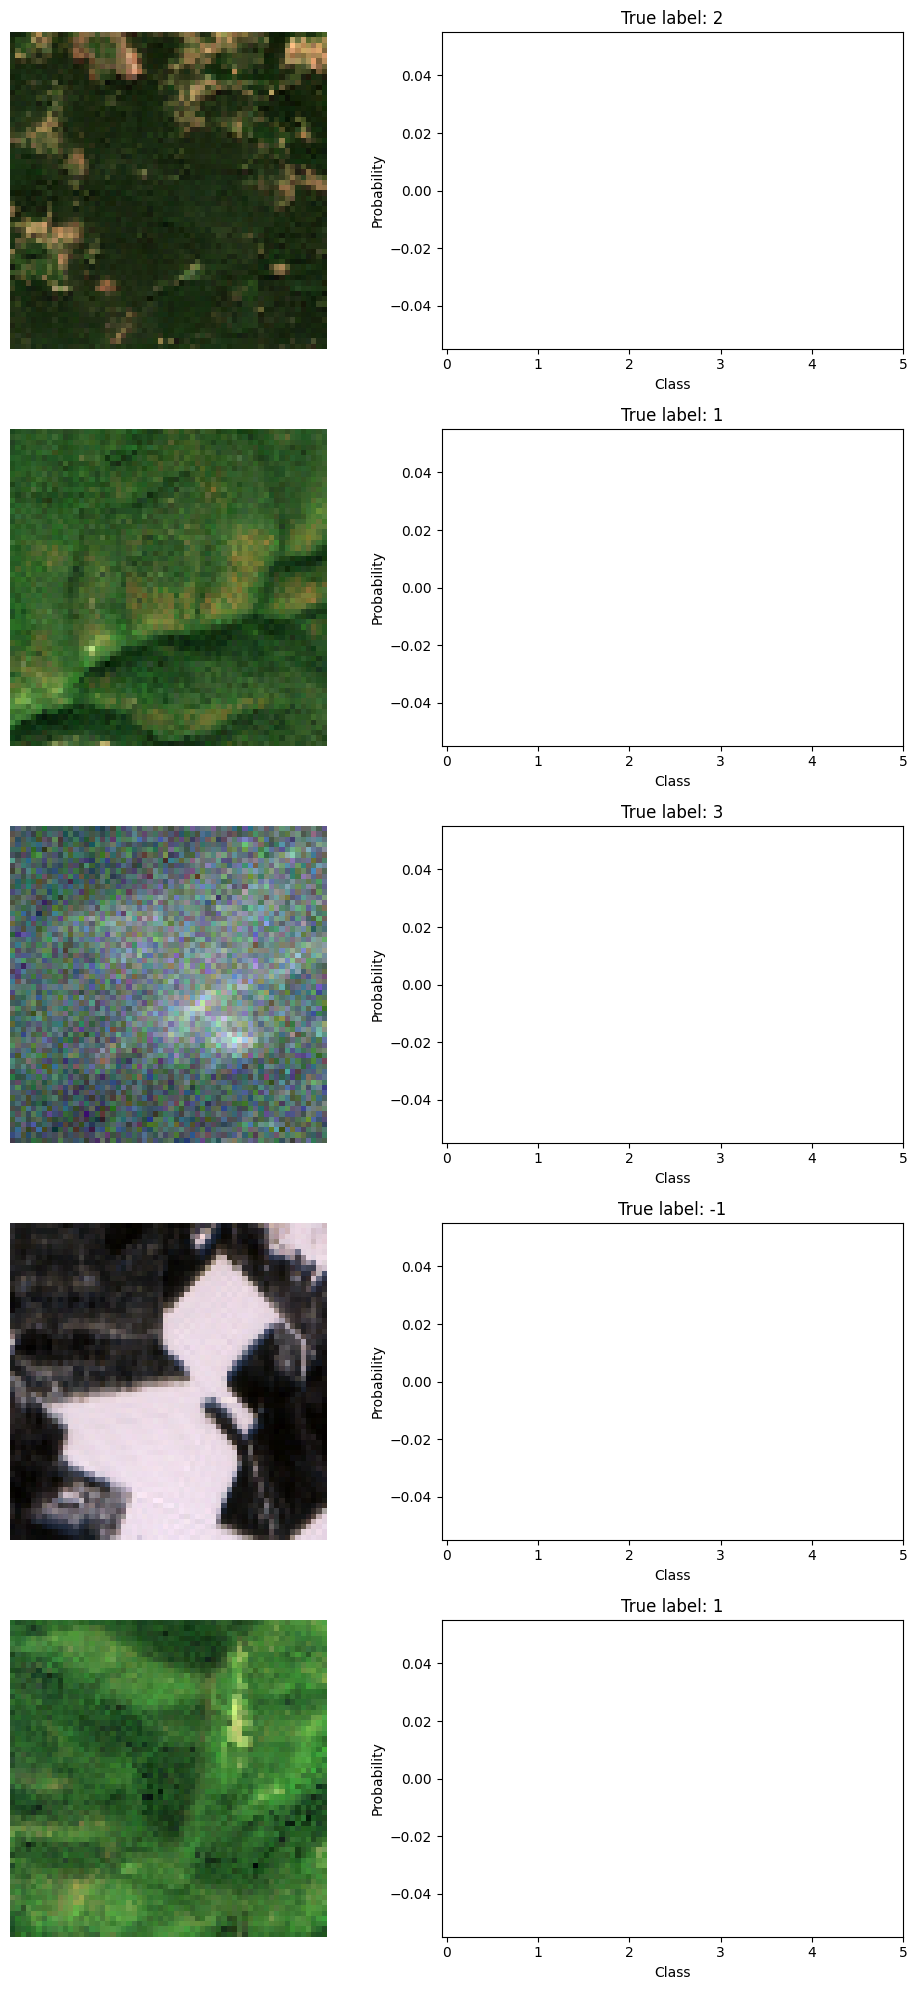

Plotting reliability diagram:


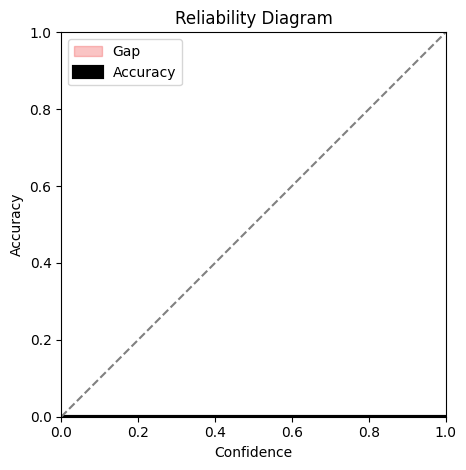

Expected Calibration Error (ECE): 0.0000
Plotting confidence distribution:


/Users/igor/opt/miniconda3/envs/pai2/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/igor/opt/miniconda3/envs/pai2/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

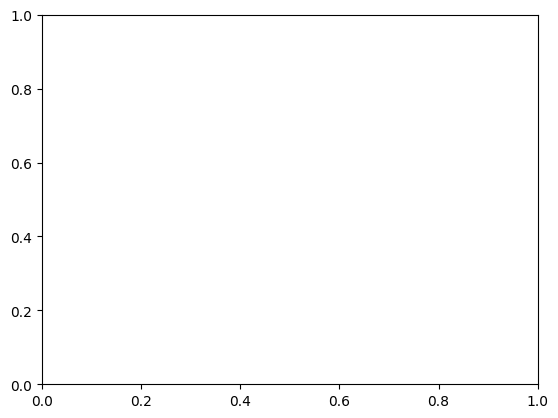

In [3]:
# Call the visualization function
data_location = Path.cwd()  # Adjust to your actual dataset path if needed
model_location = Path.cwd()  # Adjust to your actual model directory if needed

visualize_swag_diagonal(data_location, model_location)
